**Self Attention Mechanism**

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
sequence_length = 4  #max seq length #no.  of rows
batch_size = 1
input_dim = 512 #embedding dim
d_model = 512

#This function generates random numbers from a standard normal distribution.
x = torch.randn( (batch_size, sequence_length, input_dim) )
print(x)
print(x.size())

#print dim of first word in 1st batch
#print(x[0][0])

#print dim of second word in 1st batch
#print(x[0][1])




tensor([[[ 1.2452,  0.0043,  1.6617,  ..., -1.3733,  0.2543,  1.6301],
         [-1.8234, -0.7845,  1.6987,  ...,  0.2537,  0.1681,  0.7965],
         [ 0.1875,  1.3582,  0.8689,  ..., -0.7179, -0.9416, -0.9509],
         [ 0.0726, -0.2463,  0.9821,  ..., -0.7740, -0.7239, -0.0095]]])
torch.Size([1, 4, 512])


In [3]:
#Query vector, key vector, Value vector

q = torch.randn(sequence_length, input_dim)
k = torch.randn(sequence_length, input_dim)
v = torch.randn(sequence_length, input_dim)


In [4]:
print(q)

tensor([[ 0.6361, -1.6860,  1.1788,  ..., -1.7118, -0.2765,  0.0161],
        [ 0.0627,  1.3703, -1.6070,  ..., -1.2944, -0.3246, -0.2303],
        [ 0.5276, -0.5624,  1.2528,  ...,  0.2700, -1.5294,  1.5218],
        [-0.9065, -0.2774,  1.1781,  ...,  0.5973, -0.0455,  0.8183]])


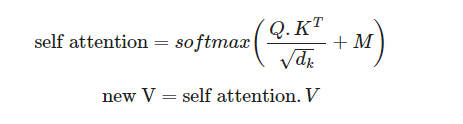

In [7]:
q.size()

torch.Size([4, 512])

**In the above formula M is a mask vector. Applicable for decoder.**

In [5]:
torch.matmul(q, k.T) #q=4*512 #k=512*4 #output=4*4

tensor([[ -4.0415, -17.8775,  17.9149, -41.1372],
        [ 19.5376,  -5.7166, -25.4592, -12.8630],
        [  2.2795,  16.9563,   3.9147,  -7.7141],
        [ 19.0931, -32.2232, -37.0650, -50.1389]])

In [8]:
q.var(), k.var(), torch.matmul(q, k.T).var() #torch can be replaced with np as well


(tensor(1.0317), tensor(0.9963), tensor(516.1777))

In [10]:
import math
#overall magnitude is controlled by scaling
scaled = torch.matmul(q, k.T) / math.sqrt(d_model)
q.var(), k.var(), scaled.var()

(tensor(1.0317), tensor(0.9963), tensor(1.0082))

In [11]:
scaled

tensor([[-0.1786, -0.7901,  0.7917, -1.8180],
        [ 0.8634, -0.2526, -1.1251, -0.5685],
        [ 0.1007,  0.7494,  0.1730, -0.3409],
        [ 0.8438, -1.4241, -1.6381, -2.2158]])

**Masking in case of decoder architecture**


In [18]:
#Preceding words are unmasked, while succeeding words are masked. # Decoder logic
mask = torch.tril(torch.ones( (sequence_length, sequence_length) ))
mask

tensor([[1., 0., 0., 0.],
        [1., 1., 0., 0.],
        [1., 1., 1., 0.],
        [1., 1., 1., 1.]])

In [19]:
mask[mask == 0] = -np.infty
mask[mask == 1] = 0
mask

tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])

In [20]:
scaled + mask

tensor([[-0.1786,    -inf,    -inf,    -inf],
        [ 0.8634, -0.2526,    -inf,    -inf],
        [ 0.1007,  0.7494,  0.1730,    -inf],
        [ 0.8438, -1.4241, -1.6381, -2.2158]])

**Softmax**

In a 2D tensor  rows represent samples and columns represent features(embedding features/dim)

[[1.0, 2.0, 3.0],

 [4.0, 5.0, 6.0]]


After Transposing:

[[1.0, 4.0],

 [2.0, 5.0],

 [3.0, 6.0]]


[[e^1.0, e^4.0],

 [e^2.0, e^5.0],

 [e^3.0, e^6.0]]


[[e^1.0 / (e^1.0 + e^4.0),
  e^4.0 / (e^1.0 + e^4.0)],

 [e^2.0 / (e^2.0 + e^5.0),
  e^5.0 / (e^2.0 + e^5.0)],
  
 [e^3.0 / (e^3.0 + e^6.0),
  e^6.0 / (e^3.0 + e^6.0)]]



Transpose back

[[0.09003057, 0.24472848, 0.66524195],

 [0.09003057, 0.24472848, 0.66524195]]


In [21]:
def softmax(x):
  return (torch.exp(x).T / torch.sum(np.exp(x), axis=-1)).T

In [23]:
#prob distribution should be summed to 1
attention = softmax(scaled + mask)

In [24]:
attention

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.7533, 0.2467, 0.0000, 0.0000],
        [0.2508, 0.4797, 0.2696, 0.0000],
        [0.8104, 0.0839, 0.0677, 0.0380]])

In [25]:
new_v = torch.matmul(attention, v)
new_v

tensor([[-1.1162, -0.6294,  2.0212,  ..., -0.6809, -0.1823, -0.1665],
        [-1.0013, -1.0173,  1.6490,  ..., -0.6599, -0.0806, -0.2107],
        [-0.4796, -1.0707,  0.8773,  ..., -0.2362,  0.1940, -0.3574],
        [-0.9019, -0.6375,  1.7149,  ..., -0.5525, -0.1039, -0.1430]])

In [27]:
print(q.shape[-1]) #4*512
print(k.shape[-1])
print(v.shape[-1])

512
512
512


**Writing Function for the same**

In [32]:
#torch can be replaced with np
def softmax(x):
  return (torch.exp(x).T / torch.sum(np.exp(x), axis=-1)).T

def scaled_dot_product_attention(q, k, v, mask=None): #mask=none for encoder and not none for decoder
  d_k = q.shape[-1]
  scaled = torch.matmul(q, k.T) / math.sqrt(d_k)
  if mask is not None:
    scaled = scaled + mask
  attention = softmax(scaled)
  out = torch.matmul(attention, v)
  return out


In [33]:
out=scaled_dot_product_attention(q,k,v,mask=mask)
print(out)

tensor([[-1.1162, -0.6294,  2.0212,  ..., -0.6809, -0.1823, -0.1665],
        [-1.0013, -1.0173,  1.6490,  ..., -0.6599, -0.0806, -0.2107],
        [-0.4796, -1.0707,  0.8773,  ..., -0.2362,  0.1940, -0.3574],
        [-0.9019, -0.6375,  1.7149,  ..., -0.5525, -0.1039, -0.1430]])
